## Historical Earthquake Data Analysis using K-Means Clustering

In [806]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
%matplotlib inline

---
### Data import

In [807]:
earthquakes_filepath = "earthquakes.tsv"
data = pd.read_csv(earthquakes_filepath, sep = "\t")
data = data[1:]
data.pop(data.columns[0])
data.head()

,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Location Name,Latitude,...,Total Missing,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description
1,1900.0,7.0,12.0,6.0,25.0,0.0,NaN,NaN,"TURKEY: KARS,KARAKURT,KAGIZMAN,DIGOR",40.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900.0,10.0,29.0,9.0,11.0,0.0,1276.0,NaN,VENEZUELA: MACUTO,11.0,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,3.0
3,1901.0,3.0,31.0,7.0,11.0,NaN,NaN,NaN,"BULGARIA: BALCHIK, KAVARNA, BLATNITSA, LIMANU",43.4,...,NaN,NaN,50.0,1.0,NaN,NaN,1200.0,4.0,NaN,NaN
4,1901.0,3.0,31.0,7.0,12.0,NaN,3725.0,NaN,BULGARIA: BALCHIK,43.4,...,NaN,NaN,50.0,1.0,NaN,3.0,1200.0,4.0,NaN,NaN
5,1901.0,8.0,9.0,18.0,33.0,45.0,1282.0,NaN,JAPAN: OFF NORTHEAST COAST HONSHU,40.6,...,NaN,NaN,NaN,NaN,NaN,2.0,8.0,1.0,NaN,NaN


In [808]:
plates_filepath = "plate_boundaries.csv"
plates = pd.read_csv(plates_filepath)
plates.head()

,plate,lat,lon
0,am,30.754,132.824
1,am,30.970,132.965
2,am,31.216,133.197
3,am,31.515,133.500
4,am,31.882,134.042


---
### Data processing

#### Combining into single date column w/ year & month

In [809]:
data = data.dropna(subset = ["Year"])
data["Year"] = data["Year"].apply(str)
lengths = data["Year"].str.len()
data["Year"] = data["Year"].str[:-2]
print(lengths.value_counts())

data = data.dropna(subset = ["Mo"])
data["Mo"] = data["Mo"].apply(str)
lengths = data["Mo"].str.len()
data["Mo"] = data["Mo"].str[:-2]
print(lengths.value_counts())

data = data.dropna(subset = ["Dy"])
data["Dy"] = data["Dy"].apply(str)
lengths = data["Dy"].str.len()
data["Dy"] = data["Dy"].str[:-2]
print(lengths.value_counts())

6    1454
Name: Year, dtype: int64
3    1109
4     345
Name: Mo, dtype: int64
4    1066
3     386
Name: Dy, dtype: int64


In [810]:
data["Year"] = data["Year"] + "/" + data["Mo"] + "/" + data["Dy"]
data.drop("Mo", axis = 1, inplace = True)
data.drop("Dy", axis = 1, inplace = True)
data.drop("Hr", axis = 1, inplace = True)
data.drop("Sec", axis = 1, inplace = True)
data.drop("Mn", axis = 1, inplace = True)
data = data.rename(columns = {"Year" : "Date"})
data["Date"] = pd.to_datetime(data["Date"])
data.head()

,Date,Tsu,Vol,Location Name,Latitude,Longitude,Focal Depth (km),Mag,MMI Int,Deaths,...,Total Missing,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description
1,1900-07-12,NaN,NaN,"TURKEY: KARS,KARAKURT,KAGIZMAN,DIGOR",40.3,43.1,NaN,5.9,8.0,140.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-10-29,1276.0,NaN,VENEZUELA: MACUTO,11.0,-66.0,NaN,7.7,10.0,25.0,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,3.0
3,1901-03-31,NaN,NaN,"BULGARIA: BALCHIK, KAVARNA, BLATNITSA, LIMANU",43.4,28.7,NaN,6.4,8.0,4.0,...,NaN,NaN,50.0,1.0,NaN,NaN,1200.0,4.0,NaN,NaN
4,1901-03-31,3725.0,NaN,BULGARIA: BALCHIK,43.4,28.5,NaN,7.2,10.0,4.0,...,NaN,NaN,50.0,1.0,NaN,3.0,1200.0,4.0,NaN,NaN
5,1901-08-09,1282.0,NaN,JAPAN: OFF NORTHEAST COAST HONSHU,40.6,142.3,33.0,8.2,NaN,18.0,...,NaN,NaN,NaN,NaN,NaN,2.0,8.0,1.0,NaN,NaN


---
### Visualizing coordinates on a scatter plot

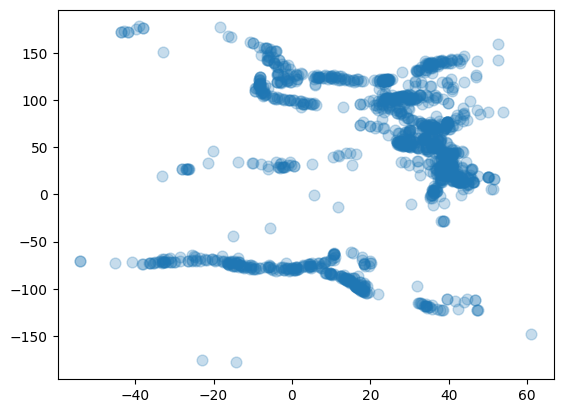

In [811]:
locations = np.array(data[["Latitude", "Longitude"]], dtype = np.float64)
plt.scatter(locations[:,0], locations[:,1], alpha = 0.25, s = 60)

Visually, there are roughly two distinct clusters.

On a time-magnitude graph...

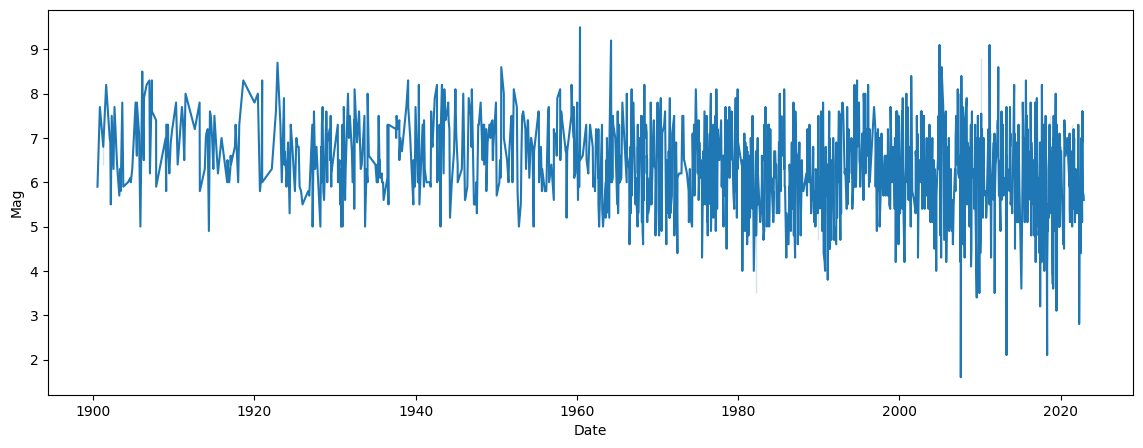

In [812]:
plt.figure(figsize= (14, 5))
timegraph = sns.lineplot(x = data["Date"], y = "Mag", data = data)

In [820]:
kmc = KMeans(n_clusters = 2)
predictions = kmc.fit_predict(locations)